In [1]:
import random
from math import factorial

import matplotlib.pyplot as plt
import numpy as np
import pymop.factory
from deap import base, creator, tools

# Problem definition
PROBLEM = "dtlz2"
NOBJ = 3
K = 10 
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) // (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
problem = pymop.factory.get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)

# Algorithm parameters
MU = int(H + (4 - H % 4))
NGEN = 400
CXPB = 1.0
MUTPB = 1.0

# Create uniform reference point
ref_points = tools.uniform_reference_points(NOBJ, P)

# Create classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialize Q-table
Q_TABLE = np.zeros((3, 3))  # 3 states, 3 actions


# Toolbox initialization
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]


toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", problem.evaluate, return_values_of=["F"])
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=30.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0 / NDIM)
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)


# RLMODE specific functions
def select_action(state):
    return np.argmax(Q_TABLE[state])


def update_q_table(state, action, reward, next_state):
    learning_rate = 0.1
    discount_factor = 0.9
    old_value = Q_TABLE[state, action]
    next_max = np.max(Q_TABLE[next_state])
    new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
    Q_TABLE[state, action] = new_value


def update_control_parameters(ind, action):
    if action == 0:
        F_f, CR_f = -0.1, 0.1
    elif action == 1:
        F_f, CR_f = 0.1, 0.1
    else:
        F_f, CR_f = 0, 0

    ind.F = ind.F + F_f
    ind.CR = ind.CR + CR_f

    if ind.F < 0 or ind.F > 1:
        ind.F = random.random()
    if ind.CR < 0 or ind.CR > 1:
        ind.CR = random.random()


def rlmode_variation(population, toolbox, cxpb, mutpb):
    offspring = []
    for ind1, ind2 in zip(population[::2], population[1::2]):
        if random.random() < cxpb:
            ind1, ind2 = toolbox.clone(ind1), toolbox.clone(ind2)
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values, ind2.fitness.values

        if random.random() < mutpb:
            ind1, = toolbox.mutate(ind1)
            del ind1.fitness.values

        if random.random() < mutpb:
            ind2, = toolbox.mutate(ind2)
            del ind2.fitness.values

        offspring.append(ind1)
        offspring.append(ind2)

        # RLMODE specific: Update control parameters
        for ind in [ind1, ind2]:
            state = random.randint(0, 2)  # Simplified state selection
            action = select_action(state)
            update_control_parameters(ind, action)
            next_state = random.randint(0, 2)  # Simplified transition
            reward = 1 if ind.fitness.valid else 0  # Simplified reward
            update_q_table(state, action, reward, next_state)

    return offspring


def main(seed=None):
    random.seed(seed)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Initialize F and CR for each individual
    for ind in pop:
        ind.F = random.random()
        ind.CR = random.random()

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Compile statistics about the population
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = rlmode_variation(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population from parents and offspring
        pop = toolbox.select(pop + offspring, MU)

        # Compile statistics about the new population
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    return pop, logbook

gen	evals	std                               	min                               	avg                               	max                               
0  	92   	[0.58459673 0.51512001 0.63835563]	[0.00168585 0.00021185 0.00407843]	[0.71459252 0.77656124 1.18580134]	[2.28320885 2.07538191 2.33951884]
1  	92   	[0.58652605 0.53987493 0.58058546]	[0.00168585 0.00021185 0.00407843]	[0.72130544 0.80332123 0.85955623]	[1.88997759 2.07141685 2.22591677]
2  	92   	[0.599223   0.53990566 0.56710884]	[0.00168585 0.0001965  0.00361764]	[0.6630096  0.76396151 0.75819558]	[1.95352921 1.84197203 2.22591677]
3  	92   	[0.60411157 0.53930909 0.56046437]	[2.01616933e-05 1.96504417e-04 5.90532523e-04]	[0.6606336  0.68473961 0.74061698]	[1.87232228 1.8824749  2.01443741]
4  	92   	[0.5891087  0.54085549 0.51629894]	[9.26088162e-07 1.79238654e-04 5.22006436e-04]	[0.69367957 0.66285835 0.64535105]	[1.90694276 1.83045891 1.78038832]
5  	92   	[0.55987771 0.52065952 0.50835096]	[9.26088162e-07 1.29849966e-04 

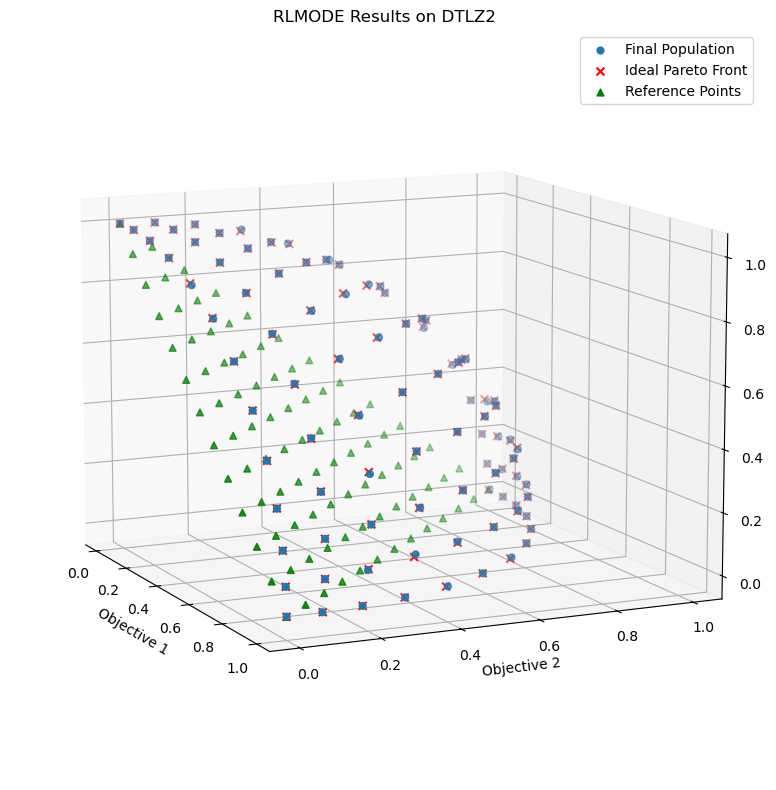

In [2]:
pop, stats = main()
pop_fit = np.array([ind.fitness.values for ind in pop])

pf = problem.pareto_front(ref_points)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

p = np.array([ind.fitness.values for ind in pop])
ax.scatter(p[:, 0], p[:, 1], p[:, 2], marker="o", s=24, label="Final Population")
ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], marker="x", c="r", s=32, label="Ideal Pareto Front")
ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], marker="^", c="g", s=24, label="Reference Points")

ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.set_zlabel("Objective 3")
ax.view_init(elev=11, azim=-25)
ax.autoscale(tight=True)
plt.legend()
plt.title("RLMODE Results on DTLZ2")
plt.tight_layout()
plt.show()

In [3]:
# Calculate and print IGD
from deap.benchmarks.tools import igd

print(f"IGD: {igd(pop_fit, pf)}")

IGD: 0.002594800658850766
